## Resolución EDO




# Resolución de una EDO Trigonométrica Simple

Consideramos una ecuación diferencial ordinaria (EDO) con condición inicial:

$$
\begin{cases}
y'(t) = \cos(t), \\
y(0) = y_0,
\end{cases}
$$
donde $y_0 = 0$ y $t \in [0,6]$.

La solución exacta de esta EDO es:

$$
y(t) = \sin(t).
$$

A continuación, definimos el código utilizando *PyTorch*:

In [61]:
# Importar librerias
import numpy as np                 # Manejo de vectores y matrices (arrays)
import torch                       # Biblioteca principal para cálculo tensorial y redes neuronales
import torch.nn as nn              # Componentes para construir redes neuronales (capas, activaciones)
import torch.optim as optim        # Algoritmos de optimización para ajustar parámetros de la red
import torch.nn.init as init       # Métodos para inicializar pesos de redes neuronales
import torch.autograd as grad      # Cálculo automático de derivadas (gradientes)
import matplotlib.pyplot as plt    # Herramientas para visualización gráfica de resultados
import time                        # Funciones para medir tiempos de ejecución
import math                        # Funciones matemáticas elementales (trigonometría, exponenciales, etc.)
import torch.nn.functional as F    # Funciones matemáticas sin parámetros para redes (activaciones, pérdidas)

In [62]:
# Semilla fijada
torch.manual_seed(1234)

In [63]:
# Datos
t0 = 0;            # Tiempo inicial
tf = 6;            # Tiempo final
y0 = 0;            # Condición inicial
Nf = 1000          # Número de puntos para evaluar el residuo (error)
print_freq = 2000  # Frecuencia para imprimir información durante el entrenamiento

In [64]:
# Definición EDO

def f(t,y):
  """
  y' = cos(t)
  """
  return torch.cos(t)

In [65]:
# Solución exacta

def exact(t):
  return torch.sin(t)

tensor([0.0000e+00, 1.5000e-03, 3.0000e-03,  ..., 5.9955e+00, 5.9970e+00,
        5.9985e+00])


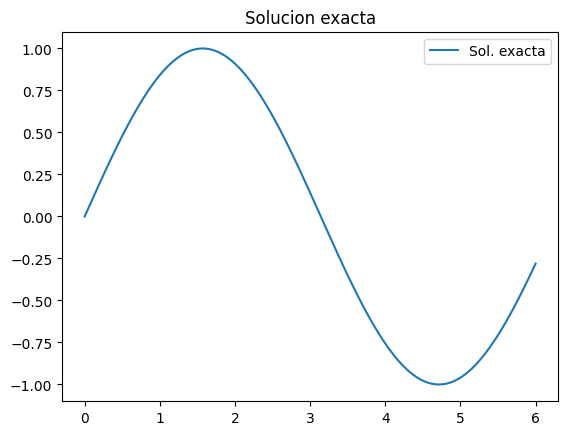

In [66]:
n = 4000;
h = (tf-t0)/n;  # Paso de tiempo

# Puntos de entrenamiento equidistantes del intervalo [t0, tf]
texact = torch.arange(t0, tf, h)
print(texact)

# Evaluación de la solución exacta en los puntos definidos
yexact = exact(texact)

# Gráfica de la solución exacta
plt.figure()
plt.plot(texact,yexact,label="Sol. exacta")
plt.legend()
plt.title("Solucion exacta")
plt.show()

### Definición Red Neuronal

In [60]:
class PINN(nn.Module):     # Clase para la red neuronal PINN

    def __init__(self, input_size, hidden_size, output_size):    # Inicializador

        super(PINN, self).__init__()                             # Inicializador de la clase base nn.Module


        # Definición de las capas de la red neuronal (3 capas lineales)
        #  nn.Linear(input_size, hidden_size)
        #  input_size : cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: cantidad de salidas (neuronas en la capa actual)
        # Capa lineal => salida = Entradas × Pesos + Sesgo

        # Capa 1: Entrada con input_size características, salida con hidden_size características
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Entrada con hidden_size características, salida con 1 característica
        self.fc3 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos:
        # 1) Random Initialization
        # Los pesos de las capas se inicializan con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # ó
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # 2) Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica
        # Ayuda a mantener una varianza constante a través de las capas
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
       # Propagación hacia adelante
       # Método forward:
       # - toma la entrada x
       # - pasa a través de las capas fc1, fc2 y fc3
       # (utiliza la función de activación tangente hiperbólica (torch.tanh) después de las dos primeras capas)
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = self.fc3(x)             # No aplicamos función de activación en la última capa fc3

       return x


### - Datos de entrenamiento:

In [67]:
print(texact.shape)              # Forma del tensor de tiempos (entrada)
print(yexact.shape)              # Forma del tensor de valores exactos (salida)

# Selección de todos los puntos (con paso 1)
t = texact[::1]
y = yexact[::1]

# Conversión a tensores 2D (columnas)
t = torch.Tensor(t).view(-1,1)   # Entrada como vector columna
y = torch.Tensor(y).view(-1,1)   # Salida como vector columna

t.shape                          # Nueva forma del tensor t

torch.Size([4000])
torch.Size([4000])


torch.Size([4000, 1])

In [68]:
# Número (deseado) de datos para el entrenamiento (ajustable)
#k = 30
#k = 100
#k = 3
#k = 17
#k = 5
k = 10

k1 = k+1             # (opcional, si se requiere un punto adicional)
j = math.ceil(n/k)   # Tamaño del paso: espaciado uniforme en los datos originales
print(j)

j = j-1              # Ajuste fino del paso (evita tomar el último punto fuera de rango)

# Selección de subconjunto de datos de entrenamiento a partir del conjunto completo
# Tomamos 1 punto cada 'j' posiciones
t_data = t[::j]      # Tiempos de entrenamiento
y_data = y[::j]      # Valores exactos correspondientes

#t_data = t[::400]
#y_data = y[::400]

# Forma de los datos de entrenamiento
t_data.shape, y_data.shape

# Tomamos 17, peor que 20
#t_data = t[::236]
#y_data = y[::236]

# Tomamos 30, parece que hay sobreentrenamiento
#t_data = t[::134]
#y_data = y[::134]

# Tomamos 3, parece que hay sobreentrenamiento
#t_data = t[::1334]
#y_data = y[::1334]

400


(torch.Size([11, 1]), torch.Size([11, 1]))

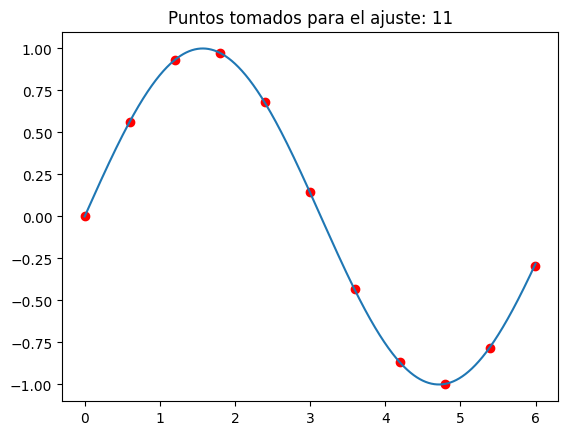

In [69]:
# Visualización de la función exacta junto con los puntos usados para entrenamiento
plt.figure()
plt.plot(t,y)
plt.scatter(t_data,y_data, c="red")
plt.title(f'Puntos tomados para el ajuste: {len(t_data)}')
plt.show()

In [70]:
# Función de entrenamiento
def train(model, optimizer,loss_fn, t_data, y_data, num_epochs):

  learning_rates = []                             # Lista --> almacena los learning rates en cada iteración/época
  loss_history = []                               # Lista --> almacena la pérdida en cada época


  for epoca in range(num_epochs):                 # Bucle de entrenamiento

    # Calcular las predicciones de la red y las derivadas
    model.train()                                 # Activación del modo de entrenamiento de la red

    y = model(t_data)                             # Predicciones de la red


    # Calcular la pérdida entre predicciones y datos reales
    loss = loss_fn(y, y_data)

    # Optimización
    optimizer.zero_grad()                         # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()                               # Se realiza la retropropagación backward
    optimizer.step()                              # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)

    loss_history.append(loss.item())              # Almacenamiento de la pérdida (error)


    current_lr = optimizer.param_groups[0]['lr']  # Obtiene learning rate actual
    learning_rates.append(current_lr)             # Almacenamiento del learning rate

    # Imprimir el progreso
    if (epoca + 1) % print_freq == 0:
      print(f'Epoch [{epoca+1}/{num_epochs}], Total Loss: {loss.item()}')

  return loss_history, learning_rates, y         # Lista de la pérdida y el lerning rate al final del entrenamiento

In [71]:
# Instancia del modelo y del optimizador

# Creación del modelo con los parámetros definidos
# model = PINN(input_size, hidden_size, output_size)
# Necesitamos como datos de entrada:
# - input_size
# - hidden_size
# - output_size

# Parámetros del modelo
input_size = 1            # Número de entradas de la red
hidden_size = 11          # Número de neuronas en la capa oculta
#hidden_size = 60         # Opciones alternativas del tamaño de la capa oculta
#hidden_size = 200
output_size = 1           # Número de salidas de la red

# Tasa de aprendizaje
learnig_rate = 0.001
# learnig_rate = 0.01

model = PINN(input_size, hidden_size, output_size)

# Definición del optimizador para la actualización de los pesos de la red
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)

# Función de pérdida para calcular el error de la red
loss_fn = nn.MSELoss()

start_time = time.time()   # Tiempo de inicio

# Número de iteraciones:
num_epoch = 20000
#num_epoch = 40000         # Otras opciones
#num_epoch = 30000
#num_epoch = 35000
#num_epoch = 48000
#num_epoch = 22000
#num_epoch =15000
#num_epoch = 10000
#num_epoch = 1000000       # Muchísimas épocas (no recomendable en muchos casos)
#num_epoch = 5000

# Entrenamos el modelo utilizando la función de entrenamiento
loss_history, learning_rates, y = train(model, optimizer, loss_fn,t_data, y_data, num_epoch)

end_time = time.time()     # Tiempo de finalización

# Calculamos el tiempo transcurrido durante el entrenamiento
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

Epoch [2000/20000], Total Loss: 0.0005653863772749901
Epoch [4000/20000], Total Loss: 9.449716344533954e-06
Epoch [6000/20000], Total Loss: 1.380252001581539e-06
Epoch [8000/20000], Total Loss: 7.024534625088563e-07
Epoch [10000/20000], Total Loss: 4.66346051553046e-07
Epoch [12000/20000], Total Loss: 3.1910920483824157e-07
Epoch [14000/20000], Total Loss: 3.124709166968387e-07
Epoch [16000/20000], Total Loss: 2.413034781056922e-05
Epoch [18000/20000], Total Loss: 2.8778566047549248e-05
Epoch [20000/20000], Total Loss: 6.876113900489145e-08
 
Tiempo de ejecución: 24.111485481262207 segundos


In [72]:
y = model(t).detach()   # Se obtiene la salida de la red con la entrada 't'
                        # .detach() evita que PyTorch rastree los gradientes para este tensor

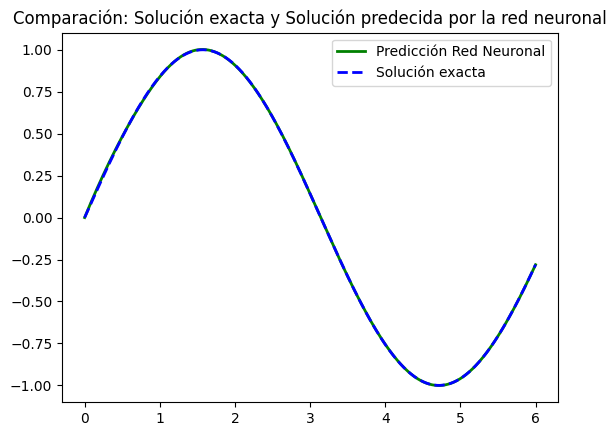

In [73]:
plt.figure()
plt.plot(t,y,c="green", linewidth=2,label ="Predicción Red Neuronal")
plt.plot(t,yexact,c ="blue", linewidth=2, linestyle='--', label='Solución exacta')
plt.legend()
plt.title("Comparación: Solución exacta y Solución predecida por la red neuronal")
plt.show()

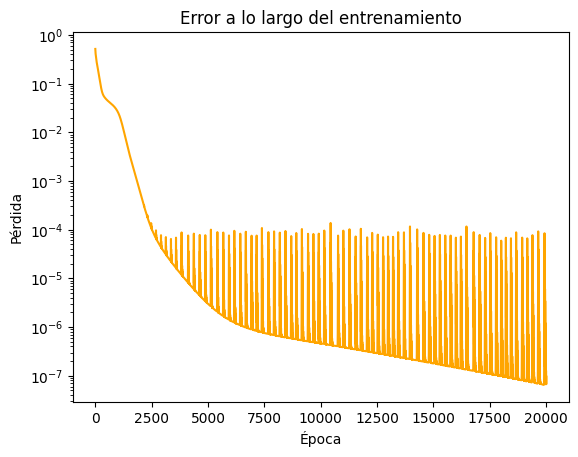

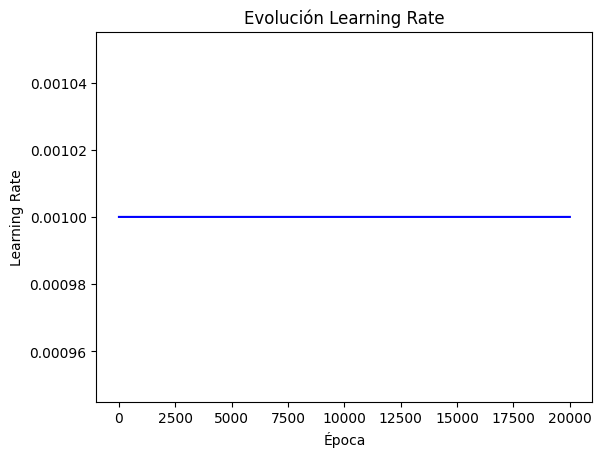

In [74]:
# Figura con dos subgráficas
plt.figure()

# Graficamos la evolución de la pérdida durante el entrenamiento
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Pérdida de entrenamiento', color='orange')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.yscale('log')         # Escala logarítmica para visualizar mejor la evolución
plt.title('Error a lo largo del entrenamiento')
plt.show()


# Graficamos la evolución del learning rate durante el entrenamiento
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='blue')
plt.xlabel('Época')
plt.ylabel('Learning Rate')
plt.title('Evolución Learning Rate')


# Ajustar el diseño y mostrar la gráfica

plt.show()